In [12]:
import os
import sys

try:
    from google.colab import drive
    IN_COLAB = True
except ModuleNotFoundError as e:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    MY_DRIVE_PATH ='/content/drive/MyDrive/Technion/Diffusion-AD-Project/'
    sys.path.append(MY_DRIVE_PATH)
    os.chdir(MY_DRIVE_PATH)
    print(f"Current working directory at {os.getcwd()}")


In [13]:
if IN_COLAB:
    !pip install blobfile &> /dev/null
    !pip install mpi4py &> /dev/null


In [14]:
# Import libraries
from typing import Tuple
from random import sample
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.models import ModelLoader
from utils.noiser import Noiser, TimestepUniformNoiser
from utils.denoiser import Denoiser, ModelTimestepUniformDenoiser, ModelTimestepDirectDenoiser
from utils.error_map import ErrorMapGenerator, BatchFilteredSquaredError
from utils.anomaly_scorer import AnomalyScorer, MaxValueAnomalyScorer
from extern.guided_diffusion.guided_diffusion import gaussian_diffusion as gd
from extern.spectral_resources.load_and_crop_img import get_sliced_bands_of_HDR_as_256x256_tensor, \
    read_bands_of_HDR_as_tensor, IMAGE_PATH_SWIR

model_loaded = False
torch.set_float32_matmul_precision('medium')


# <u>**Part 1: Import the Image**</u>

In [15]:
# Read the image and convert BGR to RGB
center_point = (510, 130)  # Note: the X-Y notation is reversed from the spectral image show so the X value in spectral is the the Y value here.
#image = Image.fromarray(get_sliced_bands_of_HDR_as_256x256_tensor([1, 10, 20], IMAGE_PATH_SWIR, center_point).numpy(), 'RGB')
spectral_im_tensor = read_bands_of_HDR_as_tensor([10, 20, 40], IMAGE_PATH_SWIR)
spectral_im_slice_tensor = get_sliced_bands_of_HDR_as_256x256_tensor(spectral_im_tensor, center_point)

Original <built-in method size of Tensor object at 0x7f80a0639710> image:


tensor([[[0.5083, 0.5434, 0.5318],
         [0.5354, 0.5473, 0.5238],
         [0.5401, 0.5425, 0.5333],
         ...,
         [0.3939, 0.3936, 0.4249],
         [0.3849, 0.3934, 0.4304],
         [0.3882, 0.3876, 0.4173]],

        [[0.4791, 0.4991, 0.4978],
         [0.5422, 0.5775, 0.5582],
         [0.5856, 0.6072, 0.5746],
         ...,
         [0.3669, 0.3707, 0.3983],
         [0.3603, 0.3719, 0.4020],
         [0.3579, 0.3653, 0.3978]],

        [[0.4946, 0.5279, 0.5255],
         [0.5763, 0.5976, 0.5897],
         [0.5864, 0.6041, 0.5756],
         ...,
         [0.3088, 0.3218, 0.3425],
         [0.3370, 0.3498, 0.3630],
         [0.3565, 0.3699, 0.3975]],

        ...,

        [[0.5287, 0.5577, 0.5936],
         [0.6084, 0.6228, 0.6446],
         [0.5997, 0.6132, 0.6215],
         ...,
         [0.5294, 0.5446, 0.5750],
         [0.5240, 0.5424, 0.5710],
         [0.5040, 0.5262, 0.5506]],

        [[0.5120, 0.5412, 0.5781],
         [0.5895, 0.6037, 0.6325],
         [0.

Transformed 256x256x3 image:


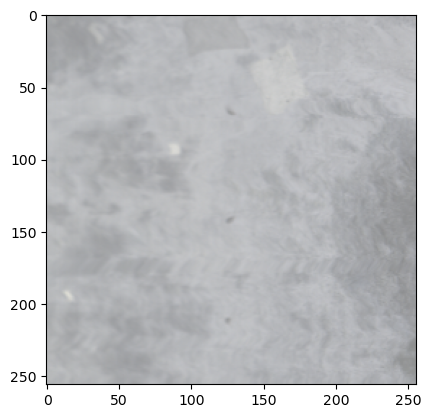

In [16]:
# Plot the chosen original image:
print(f'Original {spectral_im_tensor.size} image:')  # prev
#print(f'Original {image.shape} image:') 
display(spectral_im_tensor)  # prev

print(f'Transformed {"x".join([str(n) for n in spectral_im_slice_tensor.shape])} image:')
#plt.imshow(((img_t.permute(1, 2, 0) / 2) + 0.5).clip(0, 1), vmin=-1, vmax=1)  # prev
plt.imshow(((spectral_im_slice_tensor.permute(0, 1, 2) / 2) + 0.5).clip(0, 1), vmin=-1, vmax=1)
plt.show()

# **<u>Part 2: Noise the Image</u>**

In [17]:
torch.cuda.is_available()

True

In [18]:
# Load the model and create a corresponding diffusion object:
if not model_loaded:
    model_loader: ModelLoader = ModelLoader()
    model, diffusion = model_loader.get_model(
        '256x256_uncond', path='models/256x256_diffusion_uncond.pt')
    model_loaded = True

In [19]:
# Create a noiser object and make some noise!!
noiser = TimestepUniformNoiser(diffusion)
NUM_TIMESTEPS = 100

In [20]:
noised_image = noiser.apply_noise(spectral_im_slice_tensor.unsqueeze(0), NUM_TIMESTEPS).squeeze(0)
print(noised_image.shape)

torch.Size([256, 256, 3])


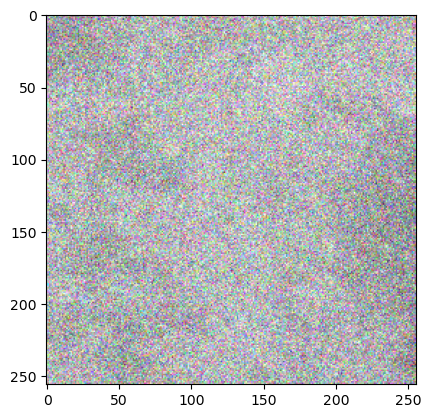

In [21]:
#plt.imshow(((noised_image.permute(1, 2, 0) / 2) + 0.5).clip(0, 1))  # prev
plt.imshow(((noised_image.permute(0, 1, 2) / 2) + 0.5).clip(0, 1))
plt.show()

# **<u>Part 3: Denoise the Image Using a Trained Model</u>**

In [22]:
# Create a denoiser and save the doge
#denoiser = ModelTimestepDirectDenoiser(model, diffusion)  # prev
denoiser = ModelTimestepUniformDenoiser(model, diffusion)
noised_image = noised_image.permute(2, 0, 1).to('cuda')
noised_image_as_batch = noised_image.unsqueeze(0)

print(noised_image.shape)
print(noised_image_as_batch.shape)

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [23]:
with torch.no_grad():
    reconstructed_image = denoiser.denoise(noised_image_as_batch, NUM_TIMESTEPS, show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

The noised image:


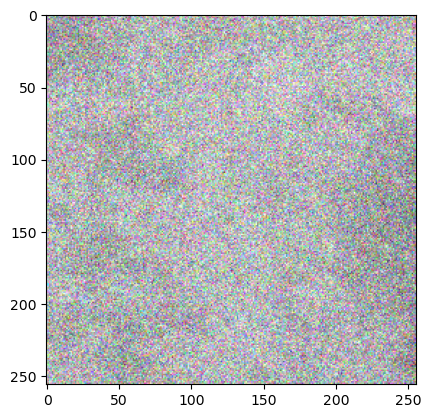

The reconstructed image:


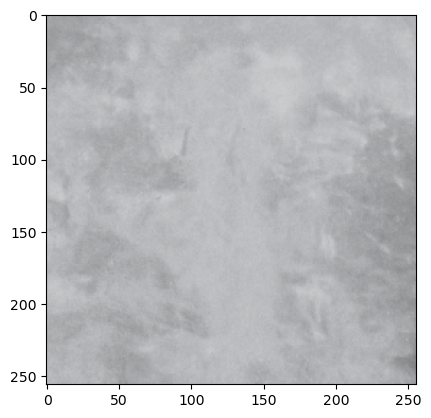

The original image:


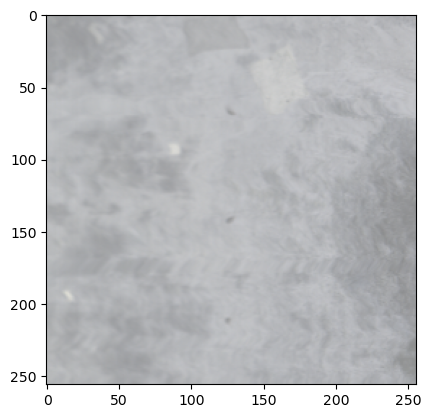

In [24]:
print('The noised image:')
noised_image_cpu = ((noised_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
plt.imshow(noised_image_cpu.permute(1, 2, 0))
plt.show()

print('The reconstructed image:')
reconstructed_image_cpu = ((reconstructed_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
plt.imshow(reconstructed_image_cpu.permute(1, 2, 0))
plt.show()

print('The original image:')
img_t_cpu = ((spectral_im_slice_tensor / 2) + 0.5).clip(0, 1)
plt.imshow(img_t_cpu)
plt.show()

In [25]:
error_map_gen = BatchFilteredSquaredError()
anomaly_scorer = MaxValueAnomalyScorer()

0.00011056845050857352 0.024907168744867345


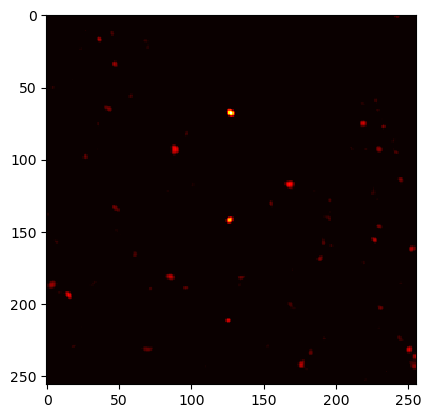

Anomaly Score: 0.02


In [26]:
anomaly_map = error_map_gen.generate(img_t_cpu.permute(2, 0, 1), reconstructed_image_cpu.unsqueeze(0))
#plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item(), vmax=anomaly_map.max().item())
plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item() * 50, vmax=anomaly_map.max().item())
print(anomaly_map.min().item(), anomaly_map.max().item())
plt.show()

print(f'Anomaly Score: {anomaly_scorer(anomaly_map):.2f}')

# **<u>Part 4: Test using multiple noise iterations</u>**

In [27]:
def get_reconstructed_batch(img: torch.Tensor,
                            noiser: Noiser,
                            denoiser: Denoiser,
                            num_timesteps: int,
                            batch_size: int,
                            interactive_print: bool = False) -> torch.Tensor:
    """
    Return:
    -------
    reconstructed_batch: Tensor
      A batch of batch_size reconstructed images from `img`.
    """
    reconstructed_batch = []

    # Noise and reconstruct `batch_size` times and aggregate into a batch
    for i in tqdm(range(batch_size)):
        curr_timesteps = torch.randint(
            low=int(num_timesteps * 0.9), high=int(num_timesteps * 1.1), size=[1]).item()
        noised_image = noiser.apply_noise(
            img.unsqueeze(0), curr_timesteps).squeeze(0).cuda()
        noised_image = noised_image.permute(2, 0, 1).to('cuda')
        
        with torch.no_grad():
            reconstructed_image = denoiser.denoise(
                noised_image.unsqueeze(0), curr_timesteps, show_progress=True)
        if interactive_print:
            print(f'Reconstructed image No. {i + 1}:')
            reconstructed_image_cpu = (
                (reconstructed_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
            plt.imshow(reconstructed_image_cpu.permute(1, 2, 0))
            plt.show()
        reconstructed_batch.append(
            ((reconstructed_image.squeeze(0) / 2) + 0.5).clip(0, 1))

    # Aggregate results into a single tensor
    device = reconstructed_batch[0].device
    reconstructed_batch = torch.stack(reconstructed_batch).to(device)

    return reconstructed_batch


def evaluate_anomaly(img: torch.Tensor,
                     reconstructed_batch: torch.Tensor,
                     error_map_gen: ErrorMapGenerator,
                     anomaly_scorer: AnomalyScorer) -> Tuple[torch.Tensor, float, torch.Tensor]:
    """
    Return:
    -------
    anomaly_map, anomaly_score
    """
    # Calculate an anomaly map using all of the results
    anomaly_map = error_map_gen.generate(img, reconstructed_batch)
    anomaly_score = anomaly_scorer.score(anomaly_map)

    return anomaly_map, anomaly_score

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Reconstructed image No. 1:


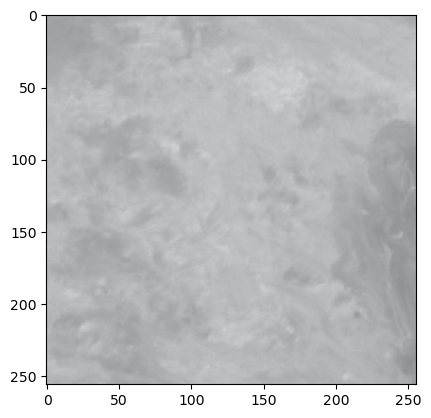

  6%|▋         | 1/16 [00:17<04:28, 17.89s/it]

  0%|          | 0/95 [00:00<?, ?it/s]

Reconstructed image No. 2:


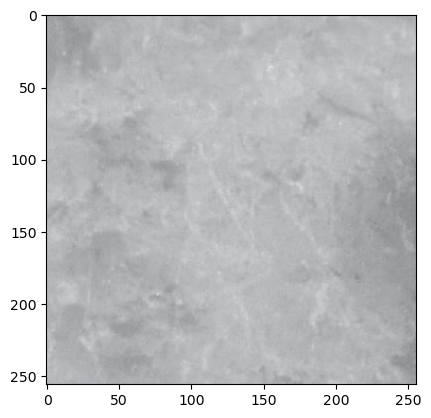

 12%|█▎        | 2/16 [00:36<04:18, 18.47s/it]

  0%|          | 0/108 [00:00<?, ?it/s]

Reconstructed image No. 3:


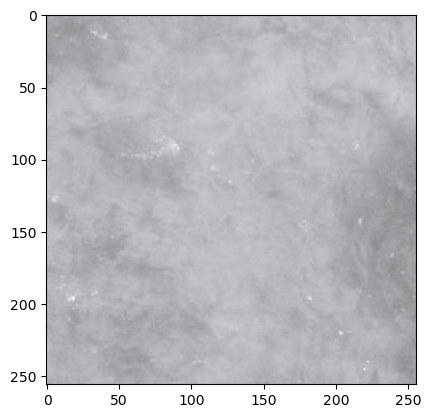

 19%|█▉        | 3/16 [00:58<04:17, 19.78s/it]

  0%|          | 0/91 [00:00<?, ?it/s]

Reconstructed image No. 4:


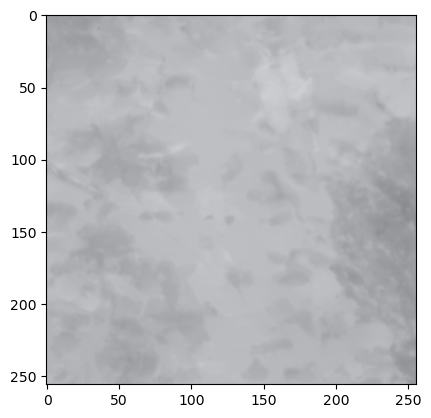

 25%|██▌       | 4/16 [01:16<03:48, 19.06s/it]

  0%|          | 0/95 [00:00<?, ?it/s]

Reconstructed image No. 5:


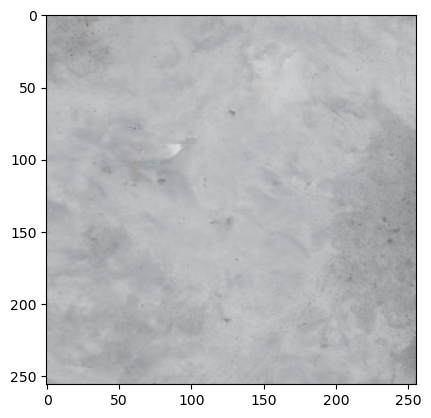

 31%|███▏      | 5/16 [01:34<03:28, 18.96s/it]

  0%|          | 0/91 [00:00<?, ?it/s]

Reconstructed image No. 6:


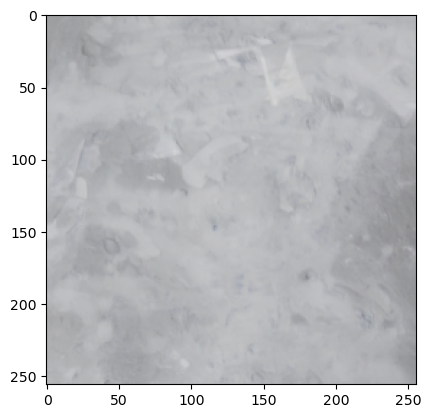

 38%|███▊      | 6/16 [01:52<03:06, 18.62s/it]

  0%|          | 0/105 [00:00<?, ?it/s]

Reconstructed image No. 7:


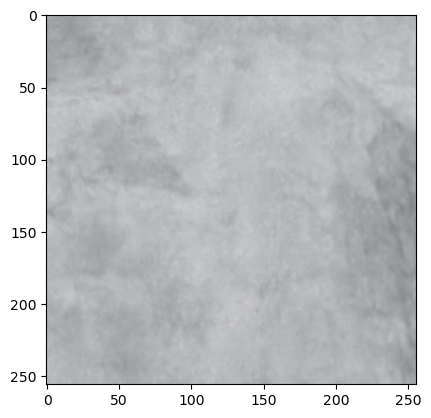

 44%|████▍     | 7/16 [02:13<02:53, 19.31s/it]

  0%|          | 0/109 [00:00<?, ?it/s]

Reconstructed image No. 8:


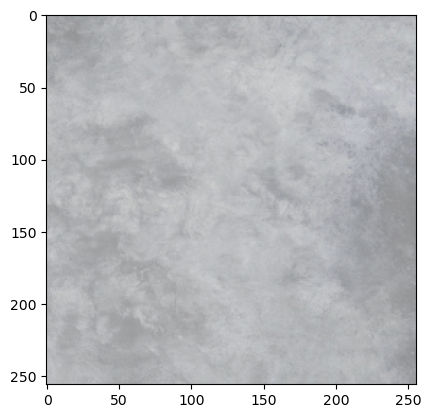

 50%|█████     | 8/16 [02:35<02:40, 20.01s/it]

  0%|          | 0/92 [00:00<?, ?it/s]

Reconstructed image No. 9:


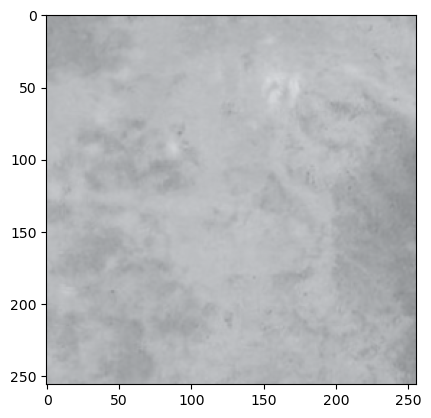

 56%|█████▋    | 9/16 [02:53<02:16, 19.43s/it]

  0%|          | 0/92 [00:00<?, ?it/s]

Reconstructed image No. 10:


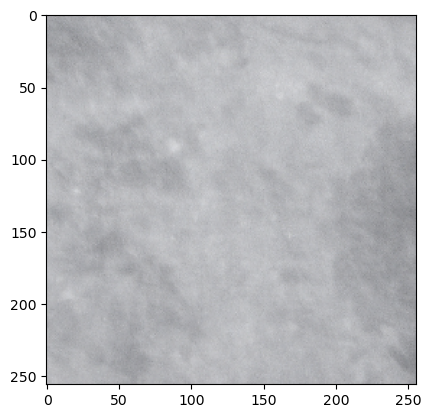

 62%|██████▎   | 10/16 [03:11<01:54, 19.04s/it]

  0%|          | 0/99 [00:00<?, ?it/s]

Reconstructed image No. 11:


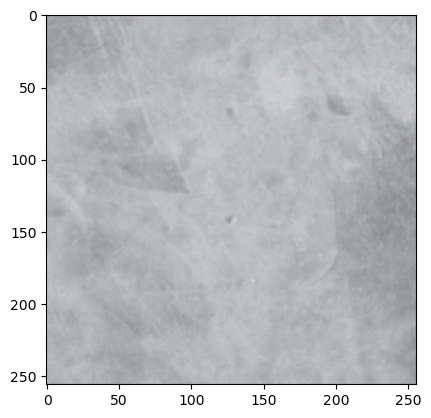

 69%|██████▉   | 11/16 [03:31<01:36, 19.24s/it]

  0%|          | 0/102 [00:00<?, ?it/s]

Reconstructed image No. 12:


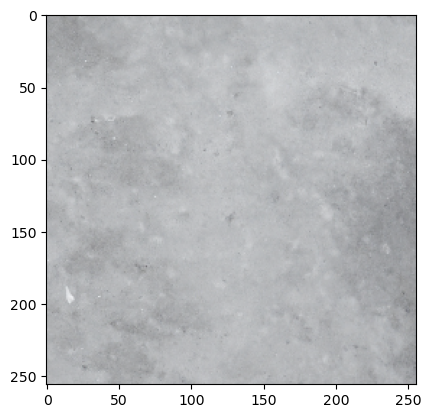

 75%|███████▌  | 12/16 [03:51<01:18, 19.54s/it]

  0%|          | 0/107 [00:00<?, ?it/s]

Reconstructed image No. 13:


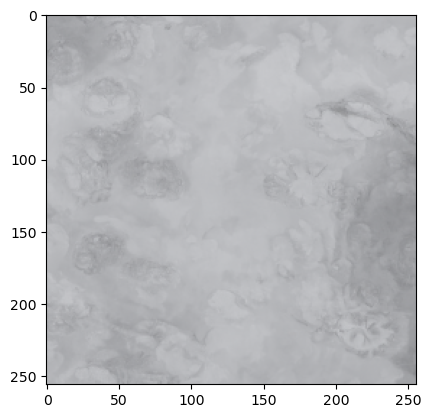

 81%|████████▏ | 13/16 [04:12<01:00, 20.01s/it]

  0%|          | 0/93 [00:00<?, ?it/s]

Reconstructed image No. 14:


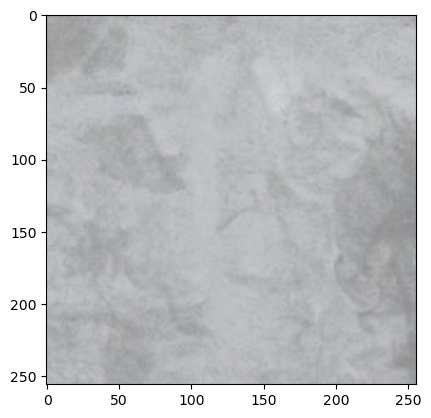

 88%|████████▊ | 14/16 [04:30<00:39, 19.51s/it]

  0%|          | 0/92 [00:00<?, ?it/s]

Reconstructed image No. 15:


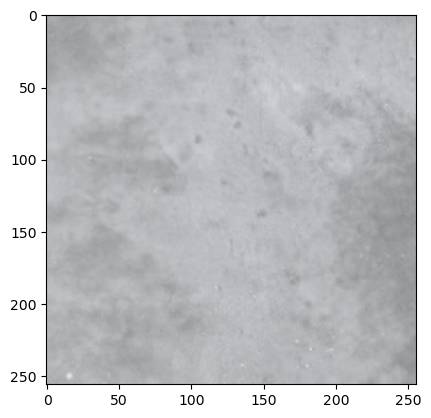

 94%|█████████▍| 15/16 [04:48<00:19, 19.11s/it]

  0%|          | 0/107 [00:00<?, ?it/s]

Reconstructed image No. 16:


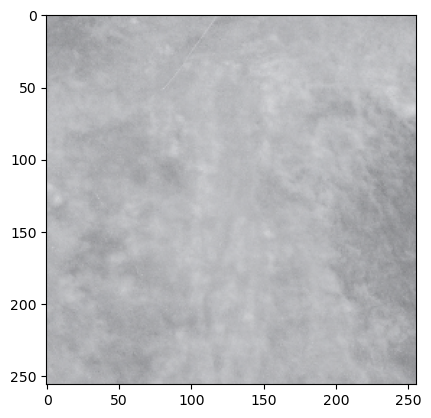

100%|██████████| 16/16 [05:10<00:00, 19.38s/it]


In [28]:
reconstructed_batch = get_reconstructed_batch(spectral_im_slice_tensor,
                                              noiser,
                                              denoiser,
                                              NUM_TIMESTEPS,
                                              batch_size=16,
                                              interactive_print=True)

In [29]:
print(f"img_t.permute(2, 0, 1): {spectral_im_slice_tensor.permute(2, 0, 1).shape}")
print(f"reconstructed_batch: {reconstructed_batch.shape}")
# Create an anomaly map averaging over all the reconstructed images
anomaly_map, anomaly_score = evaluate_anomaly(((spectral_im_slice_tensor.permute(2, 0, 1) / 2) + 0.5).cuda(),
                                              reconstructed_batch,
                                              error_map_gen,
                                              anomaly_scorer)

img_t.permute(2, 0, 1): torch.Size([3, 256, 256])
reconstructed_batch: torch.Size([16, 3, 256, 256])


The anomaly image:


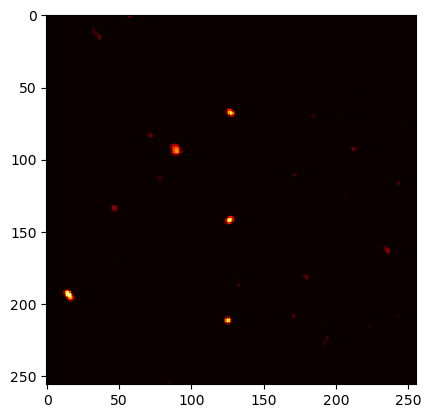

The original image:


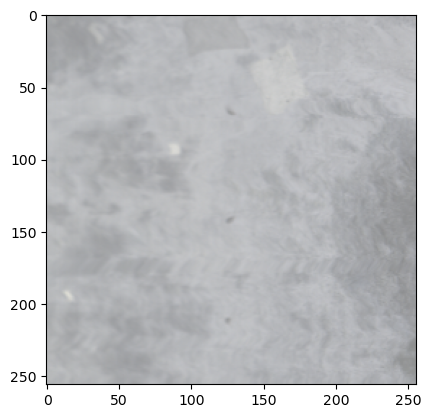

Anomaly Score: 0.01


In [30]:
anomaly_map = error_map_gen.generate(((spectral_im_slice_tensor.permute(2, 0, 1) / 2) + 0.5).cuda(), reconstructed_batch).cpu()

print('The anomaly image:')
#plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item(), vmax=anomaly_map.max().item())
plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item() * 9, vmax=anomaly_map.max().item())
plt.show()

print('The original image:')
img_t_cpu = ((spectral_im_slice_tensor / 2) + 0.5).clip(0, 1)
plt.imshow(img_t_cpu)
plt.show()

print(f'Anomaly Score: {anomaly_scorer(anomaly_map):.2f}')

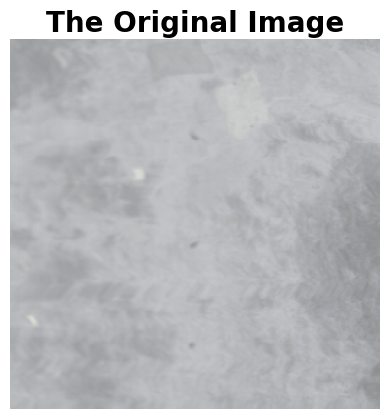

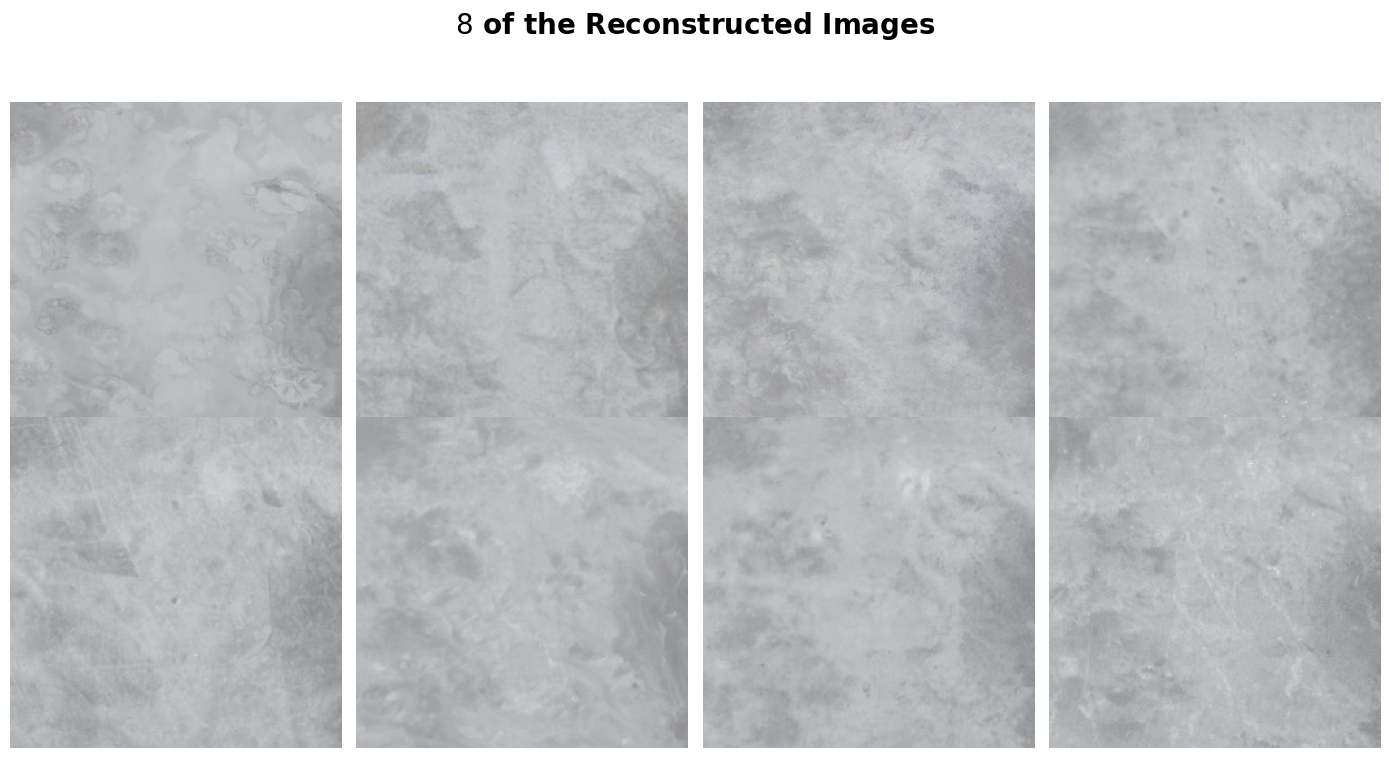

In [33]:
NUM_TO_PRINT = 8
columns = 4
rows = int(np.ceil(NUM_TO_PRINT / columns))
indices_to_plot = sample(range(len(reconstructed_batch)), NUM_TO_PRINT)

plt.imshow(img_t_cpu)
plt.title('The Original Image', fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(rows * 7, columns * 2))
fig.suptitle(f'${NUM_TO_PRINT}$ of the Reconstructed Images',
             fontsize=20, fontweight='bold')

for serial_number, i in enumerate(indices_to_plot, start=1):
    fig.add_subplot(rows, columns, serial_number)
    plt.imshow(reconstructed_batch[i].permute(1, 2, 0).cpu())
    plt.axis('off')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()